In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import tensorflow.keras.backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

from pathlib import Path
import math

#1.Preprocesado


In [53]:
df_15min = pd.read_csv('LD2011_2014.txt', sep=';', parse_dates=[0], index_col=0, decimal=',', dtype=np.float64)
df_15min.shape

(140256, 370)

In [54]:
df_15min.shape

(140256, 370)

In [55]:
#Estadisticas Basicas del dataset
df_15min.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


In [56]:
expected_freq = pd.infer_freq(df_15min.index[:8]) or "15T"
print("Inferred 15-min frequency (approx):", expected_freq)

Inferred 15-min frequency (approx): 15min


In [57]:
full_idx = pd.date_range(df_15min.index.min(), df_15min.index.max(), freq="15T")
if len(full_idx) != len(df_15min.index):
    print("Reindexing to full 15-min grid and forward-filling missing values...")
    df_15min = df_15min.reindex(full_idx).ffill()

/tmp/ipython-input-507045246.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx = pd.date_range(df_15min.index.min(), df_15min.index.max(), freq="15T")


In [58]:
df_daily = df_15min.resample("1D").sum()

print("Daily shape:", df_daily.shape)
df_daily.head(3)

Daily shape: (1462, 370)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
#funcion que me permite volver el dataset en un dataset supervisado
W = 15   # lookback window
H = 7    # forecast horizon

def make_windows(arr, window=W, horizon=H):
    X, y = [], []
    for i in range(len(arr) - window - horizon + 1):
        X.append(arr[i:i+window])
        y.append(arr[i+window:i+window+horizon].ravel())
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

In [60]:
X = np.empty(shape=(0,W))
y = np.empty(shape=(0,H))

n_cols = len(df_daily.columns)

for i in range(n_cols):
    arr = df_daily.iloc[:,i].values
    X_, y_ = make_windows(arr, W, H)
    X = np.concatenate([X, X_], axis=0)
    y = np.concatenate([y, y_], axis=0)

In [61]:
X.shape

(533170, 15)

In [62]:
y.shape

(533170, 7)

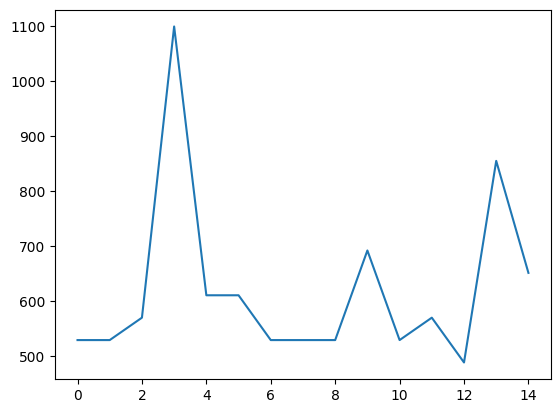

In [63]:
series = X[501250]
plt.plot(series)
plt.show()

In [64]:
permutation = np.random.permutation(len(X))

X = X[permutation]
y = y[permutation]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [67]:
X_train_scaled.shape

(319902, 15)

In [68]:
scaler2 = StandardScaler()
y_train_scaled = scaler2.fit_transform(y_train)
y_val_scaled = scaler2.transform(y_val)
y_test_scaled = scaler2.transform(y_test)

In [69]:
y_train_scaled.shape

(319902, 7)

#2.Construccion del Modelo visto en clase


In [70]:
def build_model(window=W, horizon=H):
    inputs = tf.keras.Input(shape=(window, 1))
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(horizon)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,423 (454.78 KB)

 Trainable params: 116,423 (454.78 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
ckpt_dir = Path("checkpoints"); ckpt_dir.mkdir(exist_ok=True)
ckpt_path = str(ckpt_dir / "best.keras")

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss")
]

In [72]:
ckpt_path

'checkpoints/best.keras'

In [73]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.2830 - mae: 0.0611 - val_loss: 0.0497 - val_mae: 0.0233
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0365 - mae: 0.0395 - val_loss: 0.0264 - val_mae: 0.0164
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0288 - mae: 0.0380 - val_loss: 0.0160 - val_mae: 0.0157
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0240 - mae: 0.0342 - val_loss: 0.0172 - val_mae: 0.0204
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0255 - mae: 0.0333 - val_loss: 0.0151 - val_mae: 0.0207
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0224 - mae: 0.0308 - val_loss: 0.0145 - val_mae: 0.0142
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0221 - mae: 0.0293 - val_loss: 0.0190 - val_mae: 0.0182
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0216 - mae: 0.0288 - val_loss: 0.0156 - val_mae: 0.0168
Epoch 9/50
1250/1250 ━━━━━━━━━━

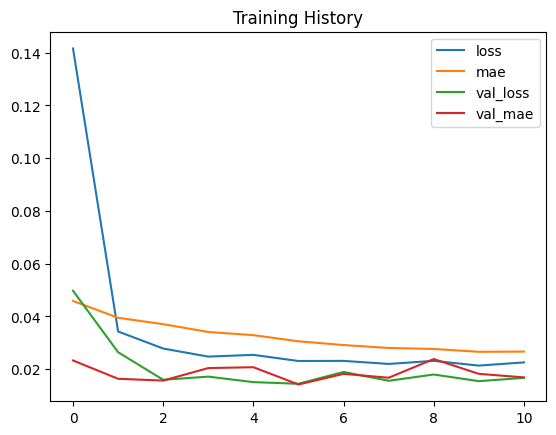

In [74]:
pd.DataFrame(history.history).plot(title="Training History")
plt.show()

#3.Evaluacion de Modelo Visto en clase

In [75]:
y_pred_scaled = model.predict(X_test_scaled, verbose=0)

In [76]:

y_test_scaled.shape

(106634, 7)

In [77]:
# Back to original units (kW)
y_test_orig = scaler2.inverse_transform(y_test_scaled)
y_pred_orig = scaler2.inverse_transform(y_pred_scaled)

#4.Construccion del Modelo con variacion en el Kernel y en los inicializadores

In [78]:
def build_model_with_inicializadores(window=W,
                                     horizon=H,
                                     kernel_init="glorot_uniform",
                                     recurrent_init="orthogonal"):

    inputs = tf.keras.Input(shape=(window, 1))
    #primera capa LTSM con el kernel y el inicializador
    x = layers.LSTM(128,
                    return_sequences=True,
                    kernel_initializer=kernel_init,
                    recurrent_initializer=recurrent_init)(inputs)
    x = layers.Dropout(0.2)(x)

    #Segunda capa LTSM con el kernel y el inicializador
    x = layers.LSTM(64,
                    kernel_initializer=kernel_init,
                    recurrent_initializer=recurrent_init)(x)

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(horizon)(x)
    model_initializador = tf.keras.Model(inputs, outputs)
    model_initializador.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model_initializador



#4.1 Modelo Gorot - Orthogonal

In [79]:
#modelo con Initialzador Glorot
model_glorot = build_model_with_inicializadores(
    kernel_init="glorot_uniform",
    recurrent_init="orthogonal")
model_glorot.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 15, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,423 (454.78 KB)

 Trainable params: 116,423 (454.78 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
ckpt_dir_1 = Path("checkpoints"); ckpt_dir_1.mkdir(exist_ok=True)
ckpt_path_1= str(ckpt_dir_1 / "best.keras")

callbacks_1 = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(ckpt_path_1, save_best_only=True, monitor="val_loss")
]

In [81]:
ckpt_path_1

'checkpoints/best.keras'

In [82]:
history_glorot = model_glorot.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=256,
    callbacks=callbacks_1,
    verbose=1
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.2316 - mae: 0.0551 - val_loss: 0.0337 - val_mae: 0.0205
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0371 - mae: 0.0393 - val_loss: 0.0234 - val_mae: 0.0167
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0276 - mae: 0.0365 - val_loss: 0.0175 - val_mae: 0.0206
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0256 - mae: 0.0344 - val_loss: 0.0184 - val_mae: 0.0144
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0282 - mae: 0.0326 - val_loss: 0.0180 - val_mae: 0.0181
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0240 - mae: 0.0307 - val_loss: 0.0145 - val_mae: 0.0144
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0223 - mae: 0.0282 - val_loss: 0.0156 - val_mae: 0.0180
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0248 - mae: 0.0284 - val_loss: 0.0276 - val_mae: 0.0219
Epoch 9/50
1250/1250 ━━━━━━━━━━

In [83]:
y_pred_scaled_glorot = model_glorot.predict(X_test_scaled, verbose=0)

In [84]:

y_test_scaled.shape

(106634, 7)

In [85]:
# Back to original units (kW)
y_test_orig = scaler2.inverse_transform(y_test_scaled)
y_pred_orig = scaler2.inverse_transform(y_pred_scaled_glorot)

#4.2 Modelo He Normal

In [86]:
model_He_normal= build_model_with_inicializadores(
    kernel_init="he_normal",
    recurrent_init="he_normal")
model_He_normal.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 15, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,423 (454.78 KB)

 Trainable params: 116,423 (454.78 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
history_He_normal = model_He_normal.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=256,
    callbacks=callbacks_1,
    verbose=1
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.3730 - mae: 0.1023 - val_loss: 0.0414 - val_mae: 0.0219
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0378 - mae: 0.0424 - val_loss: 0.0210 - val_mae: 0.0270
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0278 - mae: 0.0386 - val_loss: 0.0182 - val_mae: 0.0256
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0265 - mae: 0.0349 - val_loss: 0.0196 - val_mae: 0.0287
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0243 - mae: 0.0315 - val_loss: 0.0172 - val_mae: 0.0275
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0244 - mae: 0.0306 - val_loss: 0.0164 - val_mae: 0.0217
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0227 - mae: 0.0292 - val_loss: 0.0169 - val_mae: 0.0239
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0235 - mae: 0.0286 - val_loss: 0.0192 - val_mae: 0.0318
Epoch 9/50
1250/1250 ━━━━━━━━━━━━━

In [88]:
y_pred_scaled_he = model_He_normal.predict(X_test_scaled, verbose=0)

In [89]:
y_test_scaled.shape

(106634, 7)

In [90]:
# Back to original units (kW)
y_test_orig = scaler2.inverse_transform(y_test_scaled)
y_pred_orig = scaler2.inverse_transform(y_pred_scaled_he)

#4.3 Modelo Orthogonal

In [91]:
model_Orthogonal= build_model_with_inicializadores(
    kernel_init="orthogonal",
    recurrent_init="orthogonal")
model_Orthogonal.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 15, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,423 (454.78 KB)

 Trainable params: 116,423 (454.78 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
history_orthogonal = model_Orthogonal.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=256,
    callbacks=callbacks_1,
    verbose=1
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.2958 - mae: 0.0626 - val_loss: 0.0360 - val_mae: 0.0188
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0389 - mae: 0.0396 - val_loss: 0.0189 - val_mae: 0.0164
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0281 - mae: 0.0373 - val_loss: 0.0200 - val_mae: 0.0222
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0247 - mae: 0.0341 - val_loss: 0.0197 - val_mae: 0.0200
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0254 - mae: 0.0322 - val_loss: 0.0167 - val_mae: 0.0261
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0234 - mae: 0.0299 - val_loss: 0.0170 - val_mae: 0.0171
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0236 - mae: 0.0292 - val_loss: 0.0174 - val_mae: 0.0158
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0224 - mae: 0.0282 - val_loss: 0.0145 - val_mae: 0.0143
Epoch 9/50
1250/1250 ━━━━━━━━━━━

In [93]:
y_pred_scaled_orthogonal = model_glorot.predict(X_test_scaled, verbose=0)

#4.4 Modelo Random Normal

In [95]:
random_normal_init = tf.keras.initializers.RandomNormal(stddev=0.2)

model_random_normal= build_model_with_inicializadores(
    kernel_init=random_normal_init,
    recurrent_init=random_normal_init)

model_random_normal.summary()



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 15, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,423 (454.78 KB)

 Trainable params: 116,423 (454.78 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
history_random_normal = model_random_normal.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=256,
    callbacks=callbacks_1,
    verbose=1
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.3550 - mae: 0.0930 - val_loss: 0.0484 - val_mae: 0.0239
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0375 - mae: 0.0416 - val_loss: 0.0286 - val_mae: 0.0193
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0306 - mae: 0.0381 - val_loss: 0.0179 - val_mae: 0.0163
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0235 - mae: 0.0347 - val_loss: 0.0156 - val_mae: 0.0160
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0234 - mae: 0.0328 - val_loss: 0.0176 - val_mae: 0.0195
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0260 - mae: 0.0319 - val_loss: 0.0191 - val_mae: 0.0154
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0276 - mae: 0.0298 - val_loss: 0.0155 - val_mae: 0.0150
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0226 - mae: 0.0283 - val_loss: 0.0158 - val_mae: 0.0179
Epoch 9/50
1250/1250 ━━━━━━━━━━━